In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
MODEL = 'resnet_v1_50'
CHECKPOINT_PATH = 'resnet_v1_50.ckpt'
NUM_CLASSES = 1000
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES
IMAGE_PATH = './data/dog-yawning.jpg'

### Download the checkpoint and sample image

In [3]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')

In [18]:
checkpoint_path

'data/resnet_v1_50/resnet_v1_50.ckpt'

### Build the frozen graph

In [4]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)

W1124 17:24:35.091191 547934339088 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/tf_trt_models-0.0-py3.6.egg/tf_trt_models/classification.py:191: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1124 17:24:35.102277 547934339088 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/tf_trt_models-0.0-py3.6.egg/tf_trt_models/classification.py:195: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1124 17:24:39.914358 547934339088 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/tf_trt_models-0.0-py3.6.egg/tf_trt_models/classification.py:197: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1124 17:24:40.259118 547934339088 deprecation_wrapper.py:119] From /root/.local/lib/python3.6/site-packages/slim-0.1-py3.6.egg/nets/resnet_v1.py:221: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope

### Optimized the graph with TensorRT

In [5]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

### Create session and load graph

In [6]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

### Download and preprocess image

In [23]:
IMAGE_PATH = './data/Beavis_and_butt_head.jpg'
IMAGE_PATH = './data/Alfalfa.jpg'
#IMAGE_PATH = './data/Sunflower_test5.jpg'

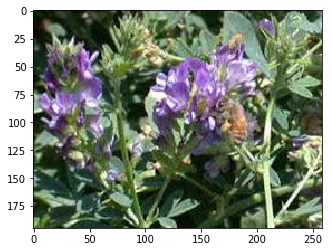

In [24]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

image = np.array(image.resize((width, height)))

### Execute model

In [25]:
output = tf_sess.run(tf_output, feed_dict={
    tf_input: image[None, ...]
})

scores = output[0]

### Get top 5 labels

In [26]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.347980) cabbage butterfly

(0.260625) monarch, monarch butterfly, milkweed butterfly, Danaus plexippus

(0.250641) cardoon

(0.044937) sulphur butterfly, sulfur butterfly

(0.039657) bee



### Close session to release resources

In [13]:
tf_sess.close()